In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# -------- Data Loading --------
# Load and combine data from all CSV files in the given folder
folder_path = "C:\Users\sahil\Sumo\2024-10-20-18-27-19\Pems_sahil\Data"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

all_data = []
for file in all_files:
    df = pd.read_csv(file)
    df['Event Timestamp'] = pd.to_datetime(df['Event Timestamp'])
    df = df.set_index('Event Timestamp')
    all_data.append(df)

data = pd.concat(all_data)
data = data.sort_index()

# Normalize the data
scaler = MinMaxScaler()
data['Vehicle Count'] = scaler.fit_transform(data[['Vehicle Count']])



# Prepare the data for LSTM
def prepare_lstm_data(data, input_window=5, output_window=3):
    X, Y = [], []
    data_values = data.values
    for i in range(len(data_values) - input_window - output_window + 1):
        X.append(data_values[i:i+input_window])
        Y.append(data_values[i+input_window:i+input_window+output_window])
    
    X = torch.tensor(np.array(X), dtype=torch.float32)
    Y = torch.tensor(np.array(Y), dtype=torch.float32)
    return X, Y

input_window = 5
output_window = 3

# Split data into train and test sets
train_size = int(0.7 * len(data))
train_data, test_data = np.split(data, [train_size])

X_train, Y_train = prepare_lstm_data(train_data, input_window, output_window)
X_test, Y_test = prepare_lstm_data(test_data, input_window, output_window)

# Create DataLoader for train and test sets
def create_dataloader(X, Y, batch_size):
    dataset = TensorDataset(X, Y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

batch_size = 8
train_loader = create_dataloader(X_train, Y_train, batch_size)
test_loader = create_dataloader(X_test, Y_test, batch_size)

# -------- Simple LSTM Model --------
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model parameters
input_dim = 1
hidden_dim = 64
output_dim = output_window

# Initialize the model
model = SimpleLSTM(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# -------- Train the Model --------
def train_model(model, train_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, Y_batch[:, -1, :])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}')

# Train the model
train_model(model, train_loader, num_epochs=10)


/Users/hiyabhatt/miniforge3/envs/mlp/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/hiyabhatt/miniforge3/envs/mlp/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 0.0191
Epoch 2, Train Loss: 0.0091
Epoch 3, Train Loss: 0.0086
Epoch 4, Train Loss: 0.0082
Epoch 5, Train Loss: 0.0079
Epoch 6, Train Loss: 0.0078
Epoch 7, Train Loss: 0.0076
Epoch 8, Train Loss: 0.0074
Epoch 9, Train Loss: 0.0073
Epoch 10, Train Loss: 0.0072


RMSE: 0.0881
R² Score: 0.7079
MAE: 0.0593
Time taken: 0.07 seconds


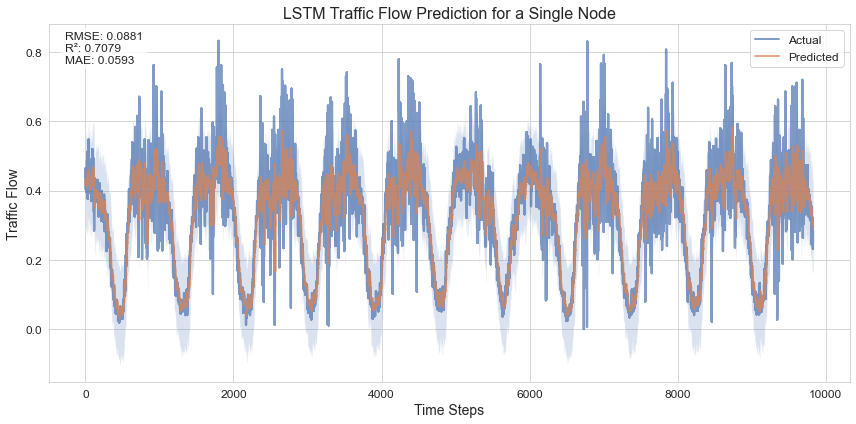

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import torch
import seaborn as sns

def visualize_predictions(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    start = time.time()
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            preds = model(X_batch).cpu().numpy()
            predictions.append(preds)
            actuals.append(Y_batch.cpu().numpy())
    end = time.time()

    # Concatenate predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Reshape predictions and actuals if necessary
    if predictions.ndim > 2:
        predictions = predictions.reshape(predictions.shape[0], -1)
    if actuals.ndim > 2:
        actuals = actuals.reshape(actuals.shape[0], -1)

    # Inverse transform the predictions and actuals
    # predictions = scaler.inverse_transform(predictions)
    # actuals = scaler.inverse_transform(actuals)

    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Time taken: {end - start:.2f} seconds")

    # Set the style for the plot
    sns.set_style("whitegrid")
    sns.set_palette("deep")

    # Plot predictions vs actuals
    plt.figure(figsize=(12, 6))
    plt.plot(actuals.flatten(), label="Actual", linewidth=2, alpha=0.7)
    plt.plot(predictions.flatten(), label="Predicted", linewidth=2, alpha=0.7)
    
    plt.legend(fontsize=12)
    plt.title("LSTM Traffic Flow Prediction for a Single Node", fontsize=16)
    plt.xlabel("Time Steps", fontsize=14)
    plt.ylabel("Traffic Flow", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Add shaded area for prediction uncertainty
    plt.fill_between(range(len(actuals.flatten())), 
                     predictions.flatten() - predictions.flatten().std(), 
                     predictions.flatten() + predictions.flatten().std(), 
                     alpha=0.2)
    
    # Add text box with metrics
    plt.text(0.02, 0.98, f'RMSE: {rmse:.4f}\nR²: {r2:.4f}\nMAE: {mae:.4f}', 
             transform=plt.gca().transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_predictions(model, test_loader)
